In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

In [3]:
URL = "neo4j://localhost:7687"
USERNAME = "neo4j"
PASSWORD = "llamaindex"

In [4]:
config = {
    "llm": {
        "provider": "openai",
        "config": {
            "model": "gpt-4o-mini",
            "temperature": 0.2,
            "max_tokens": 2000,
        }
    },
    "embedder": {
        "provider": "ollama",
        "config": {
            "model": "nomic-embed-text",
            "embedding_dims": 768
        }
    },
    "graph_store": {
        "provider": "neo4j",
        "config": {
            "url": URL,
            "username": USERNAME,
            "password": PASSWORD,
        }
    }
}

In [5]:
from mem0 import Memory

m = Memory.from_config(config_dict=config)

## Graph Visualization Utillity Functions

In [6]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from netgraph import Graph as ngGraph

def display_graph():
    # Neo4j connection configuration
    uri = URL
    username = USERNAME
    password = PASSWORD

    # Connect to Neo4j
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Updated query to return node names
    query = """
    MATCH (n)
    OPTIONAL MATCH (n)-[r]->(m)
    RETURN n.name AS source_name, type(r) AS relationship_type, m.name AS target_name
    """

    # Function to execute the query and process results
    def get_graph_data(tx):
        result = tx.run(query)
        nodes = set()
        edges = []
        for record in result:
            source_name = record["source_name"]
            target_name = record["target_name"]
            relationship = record["relationship_type"]

            if source_name:
                nodes.add(source_name)
            if target_name:
                nodes.add(target_name)
                edges.append((source_name, target_name, relationship))

        return list(nodes), edges

    # Execute the query and get results
    with driver.session() as session:
        nodes, edges = session.execute_read(get_graph_data)

    # Create a NetworkX directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    G.add_nodes_from(nodes)
    G.add_edges_from([(source, target, {'type': rel_type}) for source, target, rel_type in edges])

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 12))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Use netgraph for layout and drawing
    try:
        plot_instance = ngGraph(G, node_layout='spring', node_size=5, node_color='lightblue',
                        edge_width=0.4, edge_alpha=1, edge_color='black',
                        node_labels=True, edge_labels=nx.get_edge_attributes(G, 'type'),
                        arrows=True, ax=ax, arrowsize=1,
                        edge_arrow_width=0.5,
                        node_label_fontdict={'size': 12})
    except:
        plt.clf()
        plt.close(fig)
        ax.clear()
        plt.close('all')
        return "Nothing to Plot, add memories"

    plt.title("Mem0 Graph Memory Visualization", fontsize=20)

    # Enable zoom and pan
    def zoom_factory(ax, base_scale=2.):
        def zoom_fun(event):
            cur_xlim = ax.get_xlim()
            cur_ylim = ax.get_ylim()
            xdata = event.xdata
            ydata = event.ydata
            if event.button == 'up':
                scale_factor = 1/base_scale
            elif event.button == 'down':
                scale_factor = base_scale
            else:
                scale_factor = 1
            new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
            new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
            relx = (cur_xlim[1] - xdata)/(cur_xlim[1] - cur_xlim[0])
            rely = (cur_ylim[1] - ydata)/(cur_ylim[1] - cur_ylim[0])
            ax.set_xlim([xdata - new_width * (1-relx), xdata + new_width * (relx)])
            ax.set_ylim([ydata - new_height * (1-rely), ydata + new_height * (rely)])
            plt.draw()
        fig = ax.get_figure()
        fig.canvas.mpl_connect('scroll_event', zoom_fun)
        return zoom_fun

    zoom = zoom_factory(ax)

    def on_press(event):
        if event.inaxes != ax: return
        ax._pan_start = (event.x, event.y)

    def on_release(event):
        if event.inaxes != ax: return
        ax._pan_start = None

    def on_motion(event):
        if event.inaxes != ax: return
        if not ax._pan_start: return
        dx = event.x - ax._pan_start[0]
        dy = event.y - ax._pan_start[1]
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        scale_x = (xlim[1] - xlim[0]) / ax.get_window_extent().width
        scale_y = (ylim[1] - ylim[0]) / ax.get_window_extent().height
        ax.set_xlim(xlim - dx * scale_x)
        ax.set_ylim(ylim + dy * scale_y)
        ax._pan_start = (event.x, event.y)
        plt.draw()

    fig.canvas.mpl_connect('button_press_event', on_press)
    fig.canvas.mpl_connect('button_release_event', on_release)
    fig.canvas.mpl_connect('motion_notify_event', on_motion)

    plt.show()

    # Close the driver connection
    driver.close()

In [7]:
user_id="titus123"

### Clear Graph (Optional)

In [8]:
m.delete_all(user_id=user_id)

{'message': 'Memories deleted successfully!'}

### Add memory

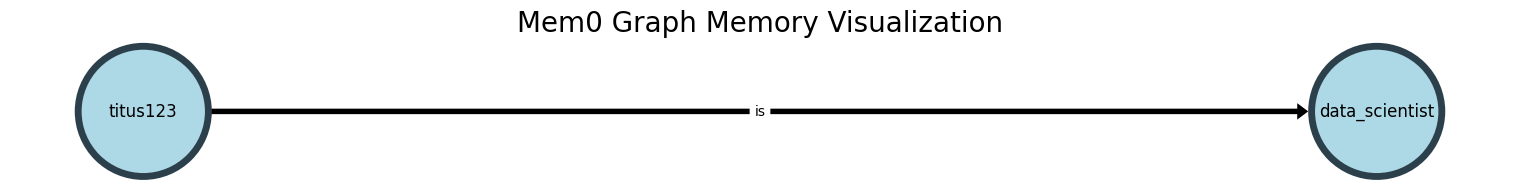

({'results': [{'id': 'ea61ec71-c93e-4760-a9e9-889908afdd1f',
    'memory': 'Is a Data Scientist',
    'event': 'ADD'}],
  'relations': {'deleted_entities': [],
   'added_entities': [[{'source': 'titus123',
      'relationship': 'is',
      'target': 'data_scientist'}]]}},
 None)

In [10]:
m.add("I am a data scientist!", user_id=user_id), display_graph()